I am really found of financial markets. After reading some books, learning some machine learning tools, joining Datacrunch community and working with their datasets using various ML models, I've got inspired to create this notebook.

The idea here is to get live quotes for a stock, create features (using RSI, Moving Averages, etc)

Then train a simple tree model on those features against the custom target.

You can use different API for finance data (yahoo finance, quandl etc)


In [4]:
#pip install yfinance

In [5]:
import pandas_datareader.data as web
import yfinance as yf 
import datetime as dt
import urllib.request, json 
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns

import pandas as pd
import numpy as np

import scipy as sp
from scipy.stats import norm, skew
from scipy.stats import spearmanr

import xgboost as xgb
import lightgbm as lgb

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples


In [6]:
#choose your dates and download your financial data
start_date = '2021-02-28'
end_date = '2014-01-01'
raw_data = {ticker: yf.download(ticker, end_date, start_date) for ticker in ['SPY', 'AAPL', 'IBM', 'MSFT', 'GOOG']}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#To make a simple example I will use only one stock, but you can use your own universe of securities

data = raw_data['AAPL']
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.598297,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,17.211735,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.305593,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,17.181829,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,17.290642,258529600
...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103916400
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,158273000
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,111039900


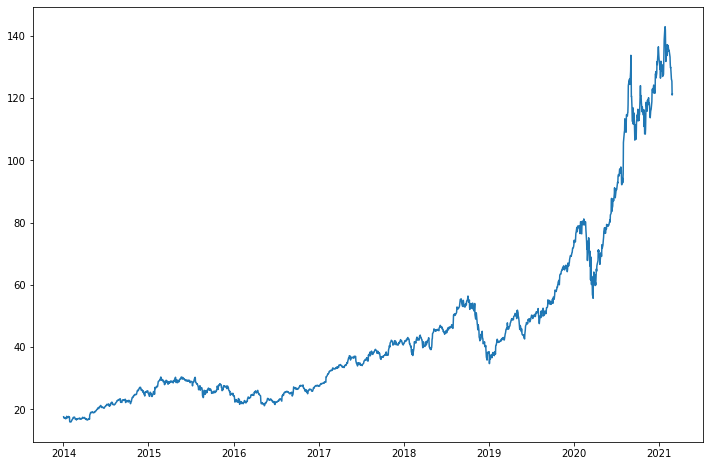

In [8]:
plt.plot(data['Adj Close'], label='Price History')

In [9]:
# Quick example of daily returns 
#AAPL
returns = data['Adj Close'].pct_change()

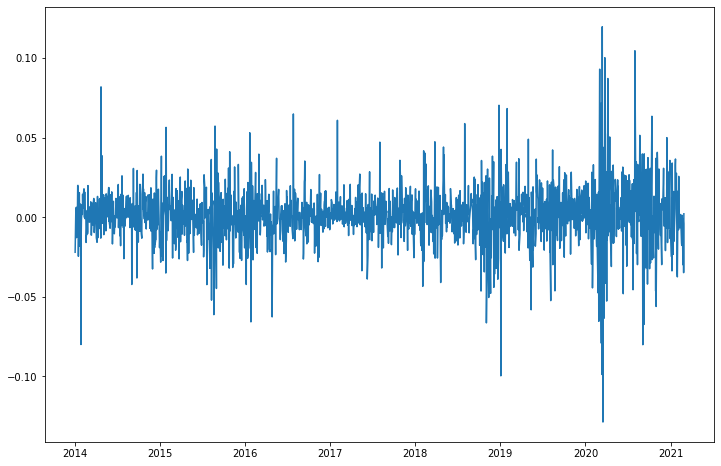

In [10]:
plt.plot(returns, label='Daily Returns History')

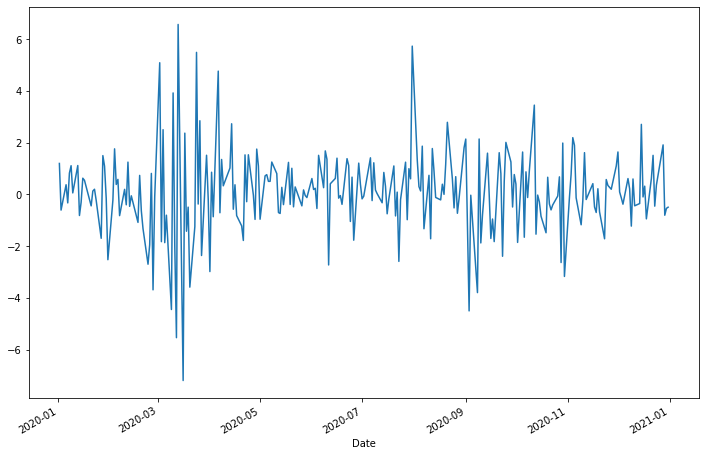

In [11]:
norm_returns = (returns - returns.mean(axis=0))/returns.std(axis=0)
norm_returns.loc['2020-01-01':'2021-01-01'].plot();

Standard Deviation:  0.018064731354045783
Mean:  0.001236164176741415
Skewness:  -0.0858688095464458
Kurtosis:  6.805857484706831


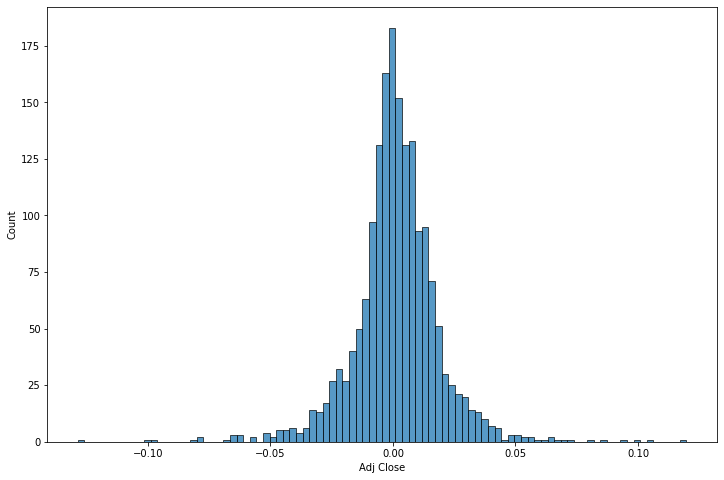

In [12]:
print ('Standard Deviation: ', returns.std())
print ('Mean: ', returns.mean())

print('Skewness: ', returns.skew())
print('Kurtosis: ', returns.kurtosis())

sns.histplot(returns)

I like the kurtosis of this stock returns and the fact that it's a little bit negative skew. However we see some fat tails (both sides), but let's be honest how without them. =)


In [13]:
data.rename(columns={'Adj Close': 'Price'}, inplace=True)

In [14]:
# Let's make our own target

#6day-2day (four market days) ranked returns for every market date
period_returns = pd.DataFrame(data['Price'].pct_change(4))

period_ranks = period_returns.rank(pct=True, method="first")


In [15]:
 # bin ranked returns 
period_ranks_bins = pd.cut(
    period_ranks['Price'],
    bins=[0, 0.05, 0.25, 0.75, 0.95, 1],
    right=True,
    labels=[0, 0.25, 0.50, 0.75, 1],
    include_lowest=True
)

In [16]:
data['target'] = pd.to_numeric(period_ranks_bins)
data.tail()

,Open,High,Low,Close,Price,Volume,target
Date,,,,,,,
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103916400,0.00
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,158273000,0.25
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,111039900,0.25
2021-02-25,124.680000,126.459999,120.540001,120.989998,120.989998,148199500,0.00
2021-02-26,122.589996,124.849998,121.199997,121.260002,121.260002,164320000,0.25


 

For this example, we'll use RSI, EMA, SMA and CMA


 - RSI is a technical indicator that attempts to measure how "oversold" or "overbought" a stock is. A good heuristic: an RSI > 70 indicates a stock is overbought and an RSI < 30 indicates a stock is oversold.

 - Moving Averages:

  - Simple Moving Average (SMA): Simple Moving Average (SMA) uses a sliding window to take the average over a set number of time periods. It is an equally weighted mean of the previous n data. 

  - An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

  - Cumulative Moving Average (CMA): Unlike simple moving average which drops the oldest observation as the new one gets added, cumulative moving average considers all prior observations. CMA is not a very good technique for analyzing trends and smoothing out the data. 

In [17]:
# more info about RSI here: https://www.investopedia.com/terms/r/rsi.asp

def RSI(prices, n = 14):
  deltas = prices.diff()

  up, down = deltas.copy(), deltas.copy()

  up[up < 0] = 0
  down[down > 0] = 0


  rolup = up.rolling(n).mean()
  roldown = down.rolling(n).mean().abs()

  rs = rolup/roldown
  rsi = 100 - 100/(1+rs)

  return rsi


def EMA (values, window):
  
  weights = np.exp(np.linspace(-1, 0, window))
  weights/= weights.sum()
  a = np.convolve(values, weights, mode = 'full')[:len(values)]
  a[:window] = a[window]

  return a

In [18]:
# you can find different kind of moving averages following this link:  https://www.datacamp.com/community/tutorials/moving-averages-in-pandas

#RSI
data['RSI'] = RSI(data['Price'], 14)
#EMA
data['EMA_15'] = EMA(data['Price'], 15)
data['EMA_12'] = EMA(data['Price'], 12)
data['EMA_26'] = EMA(data['Price'], 26)
data['EMA_9'] = EMA(data['Price'], 9)
#SMA
data['SMA_5'] = data['Price'].rolling(window=5).mean()
data['SMA_20'] = data['Price'].rolling(window=20).mean()
#CMA
data['CMA_5'] = data['Price'].expanding(min_periods=5).mean()
data['CMA_20'] = data['Price'].expanding(min_periods=20).mean()


In [19]:
data['RSI_quintile'] = data['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))
data.dropna(inplace=True)

In [20]:
#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc
num_days = 3
for day in range(num_days+1):
    data[f'RSI_quintile_lag_{day}'] = data['RSI_quintile'].transform(lambda group: group.shift(day))

In [21]:
# create difference of the lagged features (change in RSI quintile by day)
for day in range(num_days):
    data[f'RSI_diff_{day}'] = data[f'RSI_quintile_lag_{day}'] - data[f'RSI_quintile_lag_{day + 1}']
    data[f'RSI_abs_diff_{day}'] = np.abs(data[f'RSI_quintile_lag_{day}'] - data[f'RSI_quintile_lag_{day + 1}'])

In [22]:
data['RSI_quintile_lag_1'].unique()

array([nan,  0.,  1.,  4.,  3.,  2.])

In [23]:
data = data.drop(columns=['Open', 'High', 'Low', 'Close'])

Next I will add S&P 500 index to our data and calculate relative strength of our stock to S&P 500. We will understand if the stock can outperform S&P 500 and give us a better returns.

The S&P 500, or simply the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices. It might be a good idea to know the situation on the market in general and S&P can give us some clue.


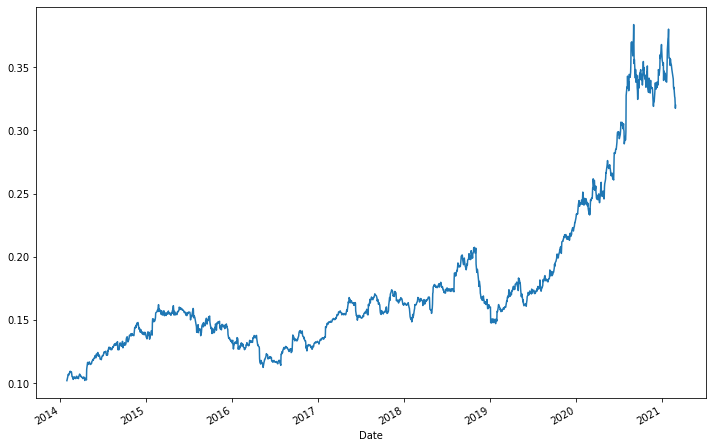

In [24]:
data['SPY'] = raw_data['SPY']['Adj Close']

data['AAPL to SPY'] = data['Price']/data['SPY']

data['AAPL to SPY'].plot()

Next I will get some sectors indices data.

Intermarket analysis is a method of analyzing markets by examining the correlations between different asset classes. In other words, what happens in one market could, and probably does, affect other markets, so a study of the relationship(s) could prove to be beneficial to the trader/investor.

And with that knowledge you can crate new features (for example the XLY to XLP ratio: when XLY is outperforming XLP, this generally means that risk appetite is increasing, and vice-versa)

There are lots of books about intermarket analysis and one may find it useful or not. It's up to you to decide, but you can definitely check out John Murphy's books.

Sectors: 
 - XLC (Communication Services)
 - XLY (Consumer Discretionary) 
 - XLP (Consumer Staples)
 - XLE (Energy) 
 - XLF (Financial) 
 - XLV (Health Care) 
 - XLI (Industrial) 
 - XLB (Materials) 
 - XLRE (Real Estate)
 - XLK (Technology)
 - XLU (Utilities) 

In [25]:
data_indx = {ticker: yf.download(ticker, end_date, start_date) for ticker in ['XLK', 'XLV', 'XLC', 'XLY', 'XLU','XLI', 'XLB', 'XLRE', 'XLF','XLE', 'XLP']}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
price = pd.DataFrame({ticker:data['Adj Close'] for ticker, data in data_indx.items()})
volume = pd.DataFrame({ticker: data['Volume'] for ticker, data in data_indx.items()})
price.head()

,XLK,XLV,XLC,XLY,XLU,XLI,XLB,XLRE,XLF,XLE,XLP
Date,,,,,,,,,,,
2014-01-02,31.635607,48.964443,NaN,60.359074,29.262381,44.611477,39.634243,NaN,15.348507,66.050415,35.017899
2014-01-03,31.483644,49.079899,NaN,60.195759,29.168468,44.732685,39.539173,NaN,15.454405,65.808189,34.951900
2014-01-06,31.429996,48.875614,NaN,59.823719,29.215427,44.472954,39.323051,NaN,15.468535,65.899025,34.819920
2014-01-07,31.716059,49.390736,NaN,60.186691,29.473692,44.749985,39.253902,NaN,15.475589,66.398659,35.009647
2014-01-08,31.716059,49.825954,NaN,60.023350,29.317163,44.672077,39.487289,NaN,15.525008,65.936859,34.745667


In [27]:
data['AAPL/XLK'] = data['Price'] / price['XLK']
data['XLK/SPY'] = price['XLK']/data['SPY']
data['XLY/XLP'] = price['XLY'] / price['XLP']

data.head()

,Price,Volume,target,RSI,EMA_15,EMA_12,EMA_26,EMA_9,SMA_5,SMA_20,CMA_5,CMA_20,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,SPY,AAPL to SPY,AAPL/XLK,XLK/SPY,XLY/XLP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-30,15.900919,678501600,0.00,35.357839,17.175884,17.265969,17.023314,17.131168,16.567144,17.157902,17.157902,17.157902,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.873276,0.102012,0.512032,0.199230,1.711173
2014-01-31,15.927006,464797200,0.00,36.821474,17.139654,17.184619,17.023314,17.040153,16.277810,17.074338,17.099288,17.099288,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,154.960114,0.102781,0.511693,0.200865,1.695281
2014-02-03,15.956603,401464000,0.50,35.849158,17.114710,17.046934,17.023314,16.886224,15.966206,17.011581,17.047348,17.047348,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,151.472687,0.105343,0.523622,0.201182,1.687180
2014-02-04,16.187578,376681200,0.50,33.991790,17.086833,16.921443,17.023314,16.711278,15.980777,16.955680,17.009967,17.009967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.533737,0.106125,0.529184,0.200544,1.698919
2014-02-05,16.308481,328344800,0.75,29.699800,17.023361,16.851748,17.023314,16.491484,16.056117,16.912013,16.980738,16.980738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.342377,0.107052,0.532669,0.200972,1.699843


In [28]:
data = data.drop(columns=['Price', 'Volume', 'SPY'])

In [29]:
data = data[data.index.weekday==4] # ensure we have only fridays

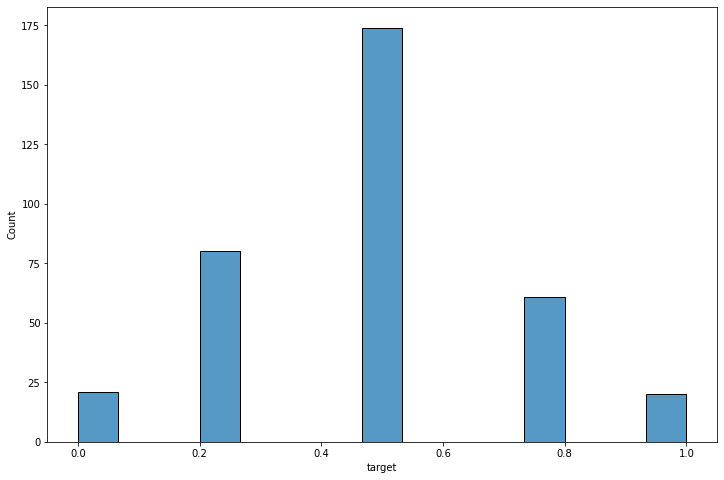

In [30]:
sns.histplot(data.target)

In [31]:
X, y = data.drop(['target'], axis = 1), data['target']

In [32]:
model = lgb.LGBMRegressor(boosting_type= 'gbdt',
                          objective= 'regression',
                          max_depth=5,
                          learning_rate=0.1, 
                          n_estimators=2000, 
                          n_jobs=-1,
                          num_leaves=31,
                          colsample_bytree = 0.01,
                          reg_alpha=0.01)

In [33]:
cv = model_selection.TimeSeriesSplit(8)

In [34]:
# Metric Spearman Rank Correlation
def spearman(y_true, y_pred): 
    return spearmanr(y_pred, y_true).correlation

In [35]:
class TimeSeriesSplitGroups(_BaseKFold):
    def __init__(self, n_splits=8):
        super().__init__(n_splits, shuffle=False, random_state=None)

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_list = np.unique(groups)
        n_groups = len(group_list)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_groups))
        indices = np.arange(n_samples)
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        test_starts = list(test_starts)[::-1]
        for test_start in test_starts:
            
            yield (indices[groups.isin(group_list[:test_start])],
                   indices[groups.isin(group_list[test_start:test_start + test_size])])

In [36]:
print(np.mean(
        model_selection.cross_val_score(
        model,
        X,
        y,
        cv=TimeSeriesSplitGroups(8),
        n_jobs=1,
        groups=X.index,
        scoring=metrics.make_scorer(spearman, greater_is_better=True)
    )))
print(cv)

0.4342731580787488
TimeSeriesSplit(max_train_size=None, n_splits=8)


In [37]:
model.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.01,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.01,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

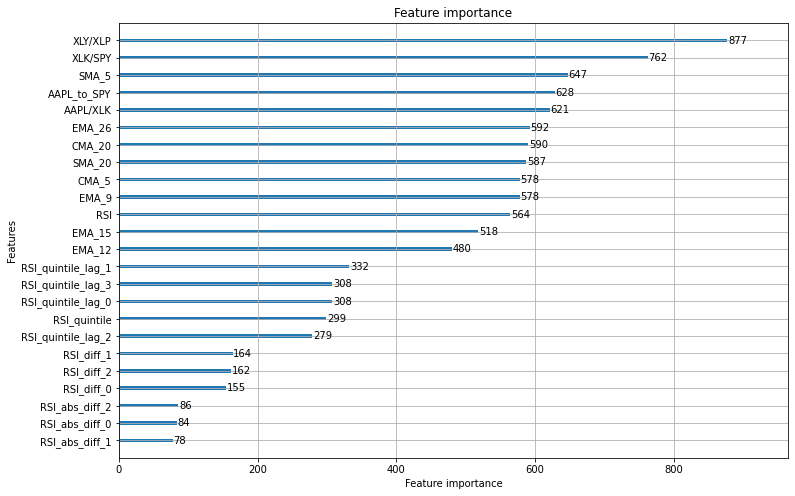

In [38]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

lgb.plot_importance(model, ax=ax)

Suggestions for improvement

I did enjoy doing this notebook. Thanks for reading and I hope it was helpful and informative for you! It isn't perfect, but it might be a good starting point. =)

 - Try different features or other technical indicators derived from price data. RSI, MA are used as an examples here, but there are many others (MACD, CCI, etc.).

 - More attention to stationarity will likely improve performance.

 - Find some other data, like fundamental.

 - Neutralize your features to sector, industry, etc, that may be specific to a group of securities.

 - Try other types of algorithms/models and tune your hyper-parameters with time-series cross-validation. https://forum.numer.ai/t/era-wise-time-series-cross-validation/791


## About
Last updated: 2021-03-31

Created by: Oksana Kalytenko

 - Twitter: [@Oxanne_k](https://twitter.com/Oxanne_k)